# Household Power Comsumption Analysis

The data used for this analysis is from https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

It contains the power consumption of one household located in France with a one-minute sampling rate over almost 4 years.

This notebook is a walkthrough on how to load temporal data and prepare it for further analysis. It also contains an exploratory data analysis to understand common patterns and behaviors found in the data.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns    
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans 
from tslearn.preprocessing import TimeSeriesScalerMinMax
plt.style.use('seaborn-colorblind')

In [2]:
# load data

filepath = './household_power_consumption.txt'

data = pd.read_csv(filepath,sep = ';',  header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]})
data.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
#rename submeters

power_consumption=data.rename(columns={"Sub_metering_1": "kitchen", "Sub_metering_2": "laundry", "Sub_metering_3": "ac/water_heater"})

In [4]:
#check the min and max dates 

print('min date: ',power_consumption.datetime.min())
print('max date: ',power_consumption.datetime.max())

min date:  2006-12-16 17:24:00
max date:  2010-11-26 21:02:00


In [5]:
# check for null values

power_consumption.isnull().sum()

datetime                     0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
kitchen                      0
laundry                      0
ac/water_heater          25979
dtype: int64

In [6]:
#convert columns to numeric format

cols = power_consumption.columns.drop(['datetime'])
power_consumption[cols] = power_consumption[cols].apply(pd.to_numeric, errors='coerce')
power_consumption.dtypes

datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
kitchen                         float64
laundry                         float64
ac/water_heater                 float64
dtype: object

In [7]:
# set column datetime as index

power_consumption=power_consumption.set_index('datetime')

In [8]:
# Linear Interpolation simply means to estimate a missing value by connecting dots in a straight line in increasing order. 
# In short, it estimates the unknown value in the same increasing order from previous values.
# other methods can also be applied to fill null values (forward fill/back fill)

power_consumption = power_consumption.interpolate(method="linear")
power_consumption.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
kitchen                  0
laundry                  0
ac/water_heater          0
dtype: int64

In [9]:
# compute for the 4th submeter

power_consumption['sub_meter_4_power'] = power_consumption['Global_active_power'] * 1000/60 - power_consumption['kitchen'] - power_consumption['laundry'] - power_consumption['ac/water_heater']
power_consumption.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,kitchen,laundry,ac/water_heater,sub_meter_4_power
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [10]:
# create new features from date column

power_consumption['year'] = power_consumption.index.year
power_consumption['quarter'] = power_consumption.index.quarter
power_consumption['month'] = power_consumption.index.month
power_consumption['day'] = power_consumption.index.day
power_consumption['hour'] = power_consumption.index.hour
power_consumption['weekday']=power_consumption.index.weekday
power_consumption['is_weekend'] = (power_consumption['weekday'] > 5).astype(int)
dic={1:'Weekend',0:'Weekday'}
power_consumption['weekday_weekend'] = power_consumption.is_weekend.map(dic)

In [11]:
# map seasons and create new columns based on season/weekday/weekend

season = {'month':[1,2,3,4,5,6,7,8,9,10,11,12],
        'season':['winter', 'winter', 'spring', 'spring', 'spring', 'summer', 'summer', 'summer', 'fall', 'fall', 'fall', 'winter']}
season = pd.DataFrame(season)
power_consumption = power_consumption.reset_index().merge(season, how="left").set_index('datetime')
power_consumption['season_weekday'] = power_consumption['season']+ power_consumption['weekday_weekend']

In [12]:
# create new dataframes based on the following frequencies: hourly, daily, weekly, monthly

power_consumption_hourly = power_consumption[['Global_active_power']].resample('H').sum()
power_consumption_daily = power_consumption[['Global_active_power']].resample('D').sum()
power_consumption_weekly = power_consumption[['Global_active_power']].resample('W').sum()
power_consumption_monthly = power_consumption[['Global_active_power']].resample('M').sum()

In [14]:
# focusing on the hourly dataframe, create new features similar to what was done before

power_consumption_hourly['year'] = power_consumption_hourly.index.year
power_consumption_hourly['quarter'] = power_consumption_hourly.index.quarter
power_consumption_hourly['month'] = power_consumption_hourly.index.month
power_consumption_hourly['day'] = power_consumption_hourly.index.day
power_consumption_hourly['hour'] = power_consumption_hourly.index.hour
power_consumption_hourly['weekday']=power_consumption_hourly.index.weekday
power_consumption_hourly['is_weekend'] = (power_consumption['weekday'] > 5).astype(int)
dic={1:'Weekend',0:'Weekday'}
power_consumption_hourly['weekday_weekend'] = power_consumption_hourly.is_weekend.map(dic)

## Exploratory Data Analysis

### Plot all metrics across time.

From the figures below, there is a noticeable low usage in 2008-08 which is also reflective in the four submeters. This could be a time when the family went for a summer vacation.

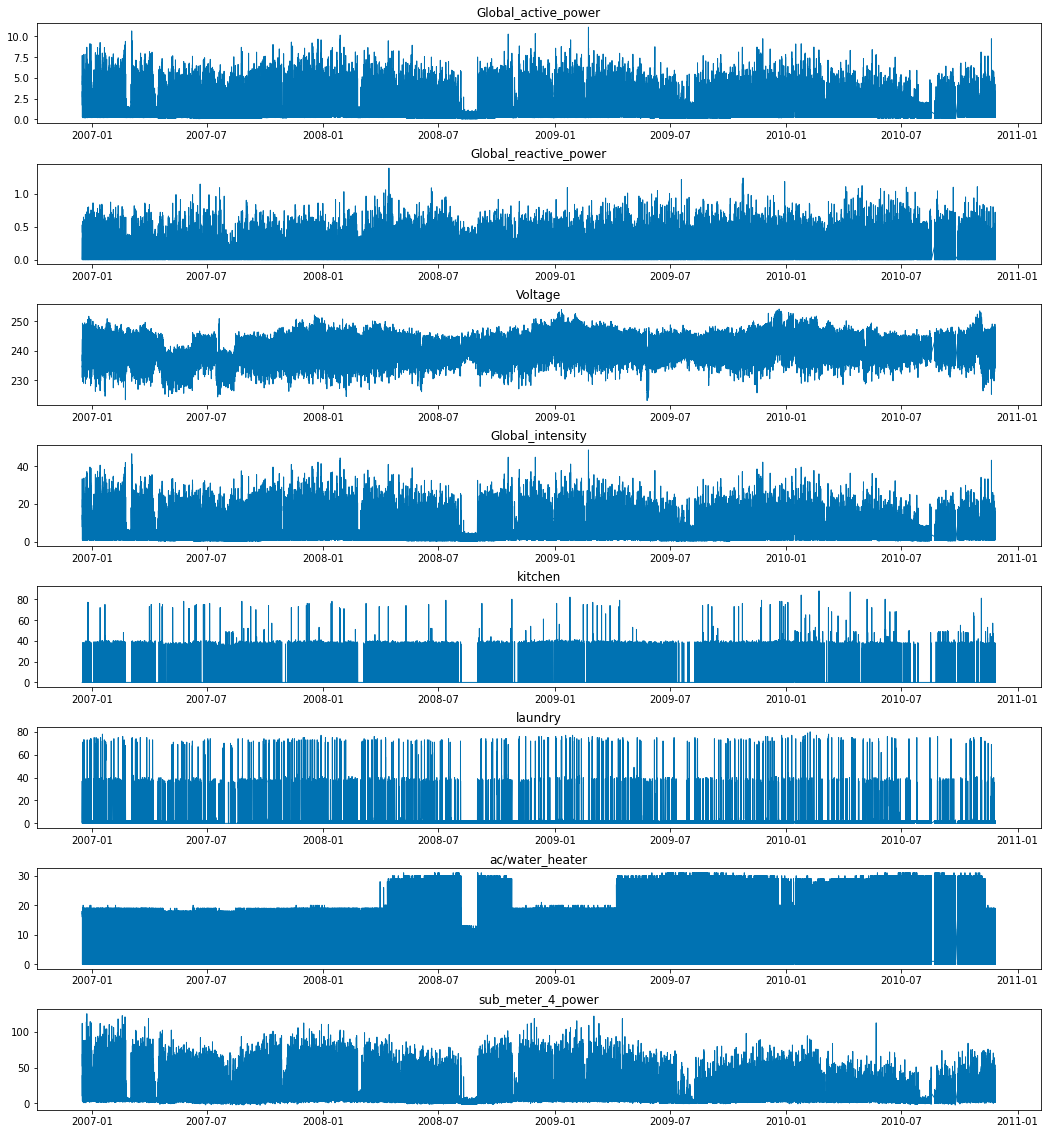

In [19]:
plt.figure(figsize=(18,20))

cols= ['Global_active_power', 
       'Global_reactive_power', 
       'Voltage', 
       'Global_intensity', 
       'kitchen', 
       'laundry', 
       'ac/water_heater', 
       'sub_meter_4_power', 
       ]

for i, col in enumerate(cols):
    plt.subplot(8,1,i+1)
    plt.subplots_adjust(hspace=.4)
    plt.plot(power_consumption[col], linewidth=1)
    plt.xlabel('')
    plt.title(col)

### Plot global active power across months and compare by year.

2007 to 2010 follow the same pattern where power usage is high on first month of the year then dips until third quarter. Usage starts to increase again towards end of the year. This might be due to the 4 seasons experienced in France.

August 2008 had a noticeable dip compared to other years of same month. Same behavior is also evident in previous plot where the submeters' usage went down around the same period. 

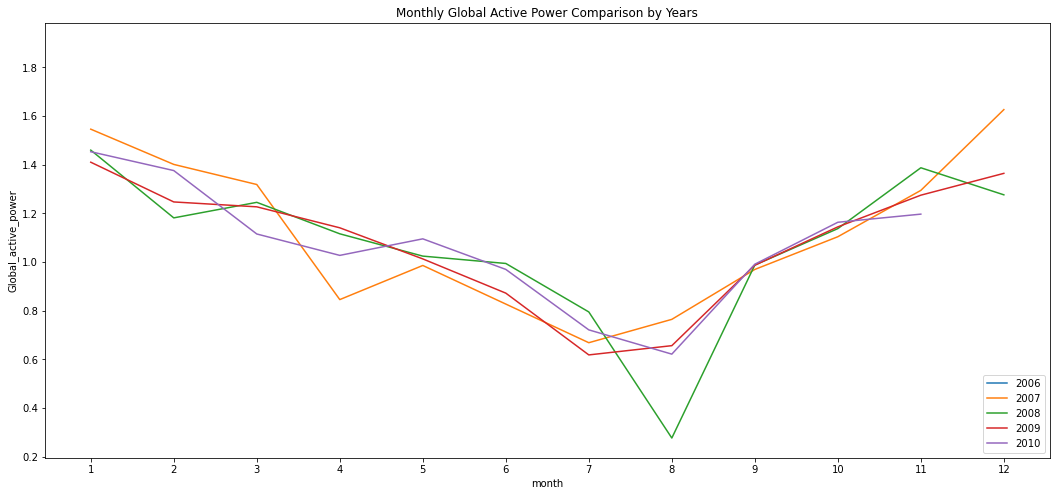

In [21]:
ax1 = sns.lineplot(data=power_consumption, x='month', y='Global_active_power',
                  hue='year',ci=None,palette="tab10")
ax1.figure.set_size_inches(18, 8)
ax1.set_xticks(power_consumption['month'].unique())
ax1.set_title('Monthly Global Active Power Comparison by Years')
ax1.legend(ax10.lines, power_consumption['year'].unique(), title='year')
plt.legend(loc='lower right')
plt.show()

### Plot hourly global active power usage.

- As expected, winter power usage is higher compared to other seasons. Fall and Spring follow a close usage pattern however, fall has notably higher usage during 6-7am and 6-10pm. 
- Weekday power usage is higher from 5-10am - this might be due to preparation time before going to office/school. On the otherhand, weekend usage is higher except during 5-10am - this might be due to later start of the day during weekends compared to weekdays.

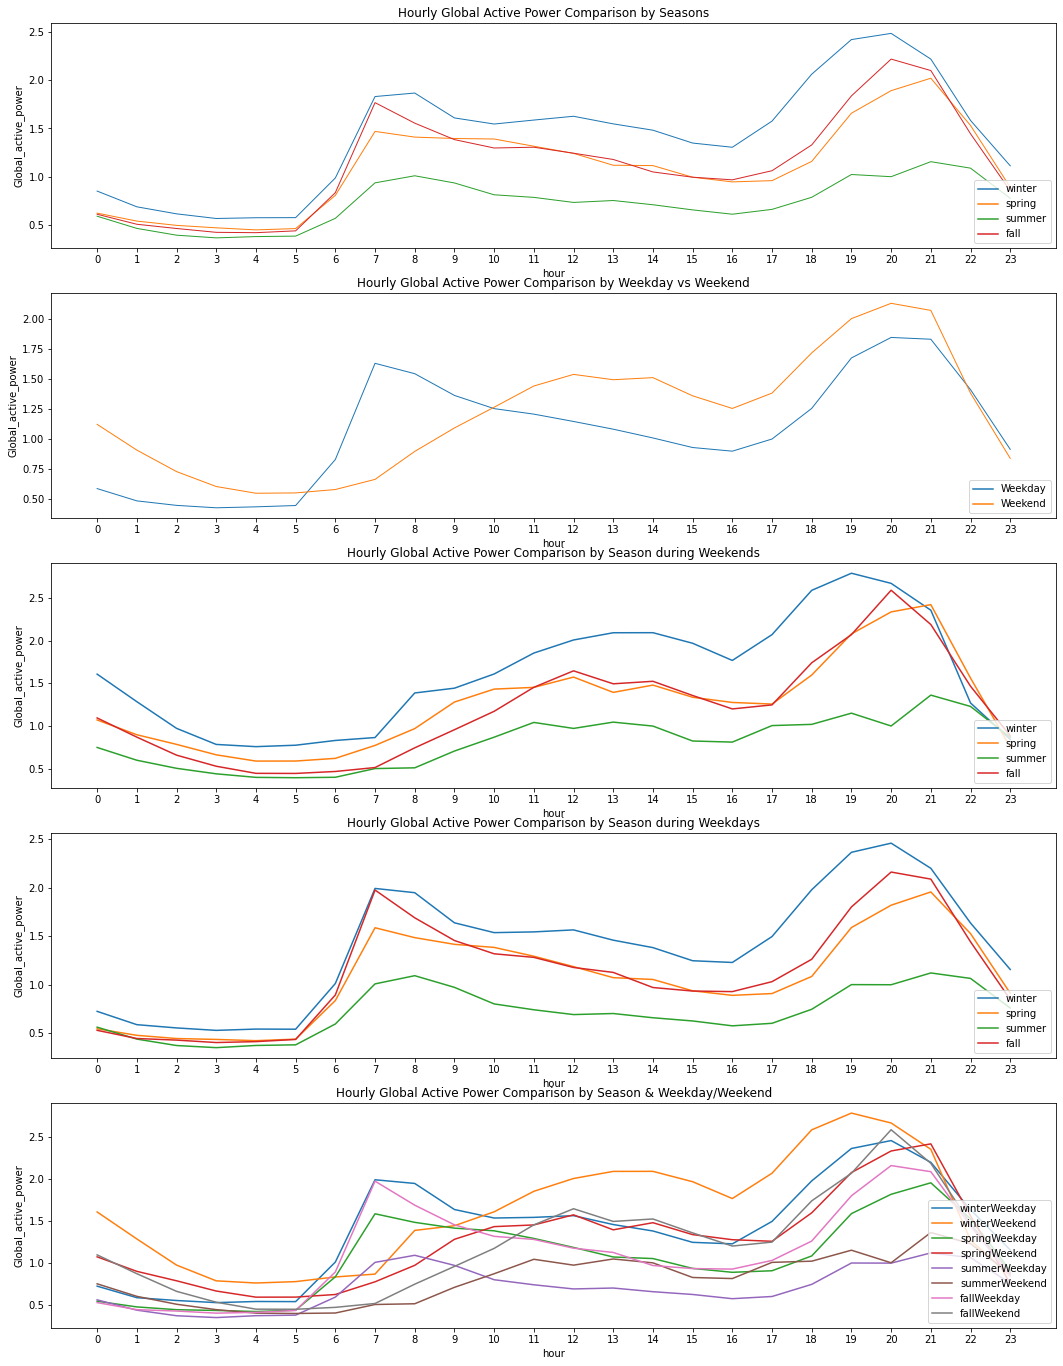

In [22]:
fig, axes = plt.subplots(5, 1)

ax11=sns.lineplot(data=power_consumption, x='hour', y='Global_active_power',
                  hue='season',ci=None,palette="tab10", linewidth=1, ax=axes[0])
ax11.figure.set_size_inches(18, 24)
ax11.set_xticks(power_consumption['hour'].unique())
ax11.set_title('Hourly Global Active Power Comparison by Seasons')
ax11.legend(ax11.lines, power_consumption['season'].unique(), title='season')
ax11.legend(loc='lower right')

ax12=sns.lineplot(data=power_consumption, x='hour', y='Global_active_power',
                  hue='weekday_weekend',ci=None,palette="tab10", linewidth=1, ax=axes[1])
ax12.set_xticks(power_consumption['hour'].unique())
ax12.set_title('Hourly Global Active Power Comparison by Weekday vs Weekend')
ax12.legend(ax12.lines, power_consumption['weekday_weekend'].unique(), title='weekday_weekend')
ax12.legend(loc='lower right')

ax13=sns.lineplot(data=power_consumption[power_consumption['is_weekend']==1], x='hour', y='Global_active_power',
                  hue='season',ci=None,palette="tab10", ax=axes[2])
ax13.set_xticks(power_consumption['hour'].unique())
ax13.set_title('Hourly Global Active Power Comparison by Season during Weekends')
ax13.legend(ax13.lines, power_consumption['season'].unique(), title='season')
ax13.legend(loc='lower right')

ax14=sns.lineplot(data=power_consumption[power_consumption['is_weekend']==0], x='hour', y='Global_active_power',
                  hue='season',ci=None,palette="tab10", ax=axes[3])
ax14.set_xticks(power_consumption['hour'].unique())
ax14.set_title('Hourly Global Active Power Comparison by Season during Weekdays')
ax14.legend(ax14.lines, power_consumption['season'].unique(), title='season')
ax14.legend(loc='lower right')

ax15=sns.lineplot(data=power_consumption, x='hour', y='Global_active_power',
                  hue='season_weekday',ci=None,palette="tab10", ax=axes[4])
ax15.set_xticks(power_consumption['hour'].unique())
ax15.set_title('Hourly Global Active Power Comparison by Season & Weekday/Weekend')
ax15.legend(ax15.lines, power_consumption['season_weekday'].unique(), title='season_weekday')
ax15.legend(loc='lower right')

### Plot global active power usage by quarter, month, day, hour, weekday v weekend, season.

- As previously observed, there is a dip in global active power usage during Q3/summer season
- There is an increase in usage on weekends
- Daily peak hours are during morning and evening

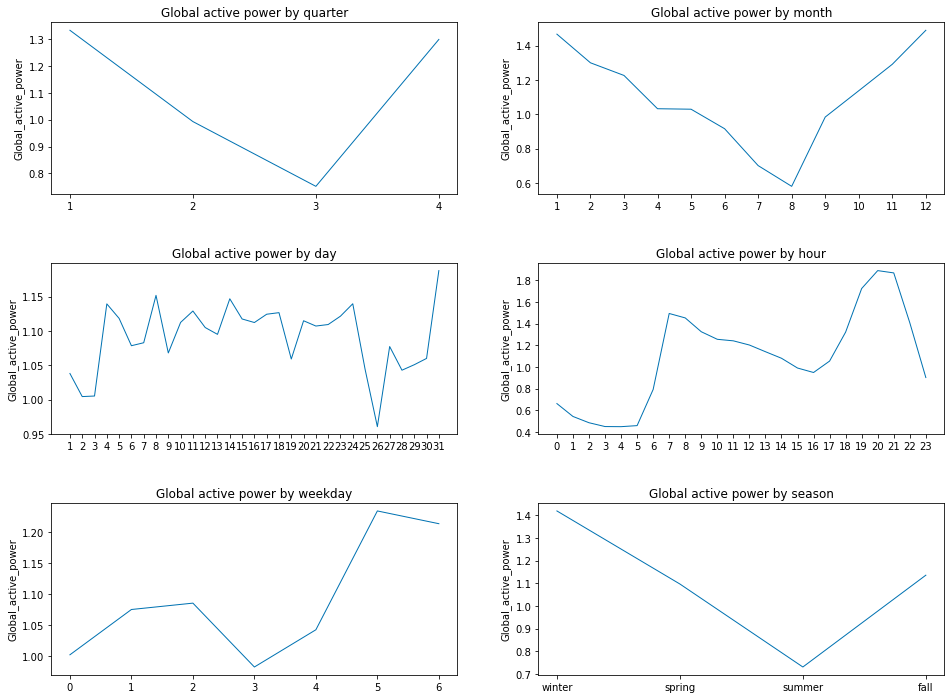

In [25]:
plt.figure(figsize=(16,12))

cols= ['quarter', 
       'month', 
       'day', 
       'hour', 
       'weekday', 
       'season', 
       ]

for i, col in enumerate(cols):
    plt.subplot(3,2,i+1)
    plt.subplots_adjust(hspace=.4)
    sns.lineplot(data=power_consumption, x=col, y='Global_active_power',
                  ci=None,palette="tab10", linewidth=1).set_xticks(power_consumption[col].unique())    
    plt.xlabel('')
    plt.title('Global active power by ' + col)

### Plot hourly submeters usage.

- Kitchen usage increase at 2 time points - 6am and 5pm
- Laundry usage peaks at around 12nn to 2pm
- AC/water heater usage increase at 2 time points as well - 5am and 6pm
- The 4th submeter usage has 2 noticeable peaks as well - morning and evening

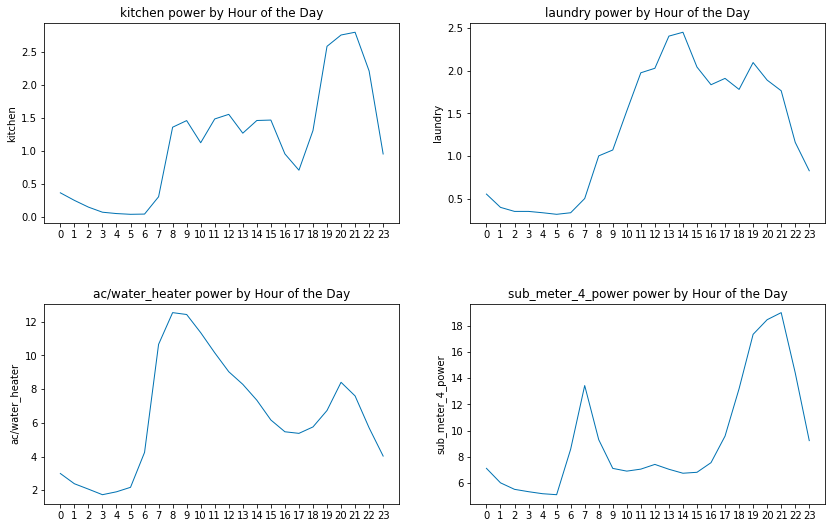

In [29]:
plt.figure(figsize=(14,14))

cols= ['kitchen', 
       'laundry', 
       'ac/water_heater', 
       'sub_meter_4_power', 
       ]

for i, col in enumerate(cols):
    plt.subplot(3,2,i+1)
    plt.subplots_adjust(hspace=.4)
    sns.lineplot(data=power_consumption, x='hour', y=col,
                  ci=None,palette="tab10", linewidth=1).set_xticks(power_consumption['hour'].unique())    
    plt.xlabel('')
    plt.title(col + ' power by Hour of the Day')

### Plot daily submeters usage.

- Kitchen usage is higher on weekends
- Laundry usage has 2 peaks - Wednesdays and Sundays
- AC/water heater usage is highest on Saturdays
- 4th submeter usage is higher on weekends

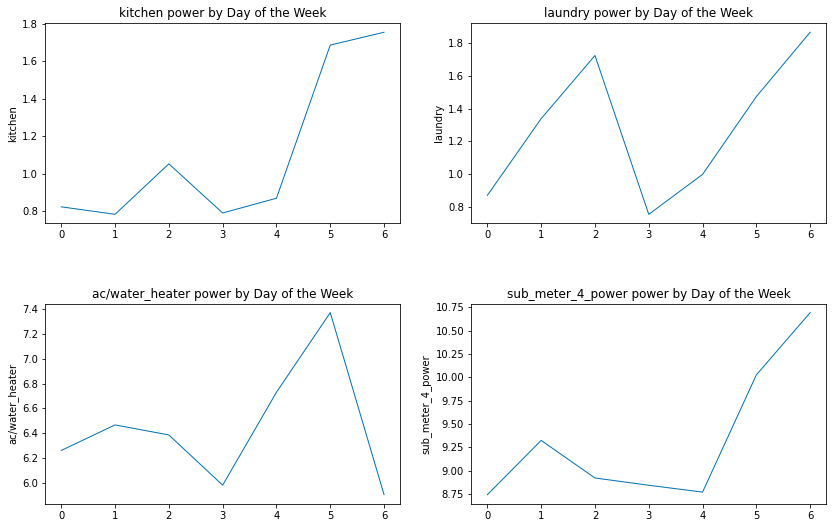

In [31]:
plt.figure(figsize=(14,14))

cols= ['kitchen', 
       'laundry', 
       'ac/water_heater', 
       'sub_meter_4_power', 
       ]

for i, col in enumerate(cols):
    plt.subplot(3,2,i+1)
    plt.subplots_adjust(hspace=.4)
    sns.lineplot(data=power_consumption, x='weekday', y=col,
                  ci=None,palette="tab10", linewidth=1).set_xticks(power_consumption['weekday'].unique())    
    plt.xlabel('')
    plt.title(col + ' power by Day of the Week')

### Plot seasonal submeters usage.

- All submeters' usage is highest on winter season and lowest during summer season

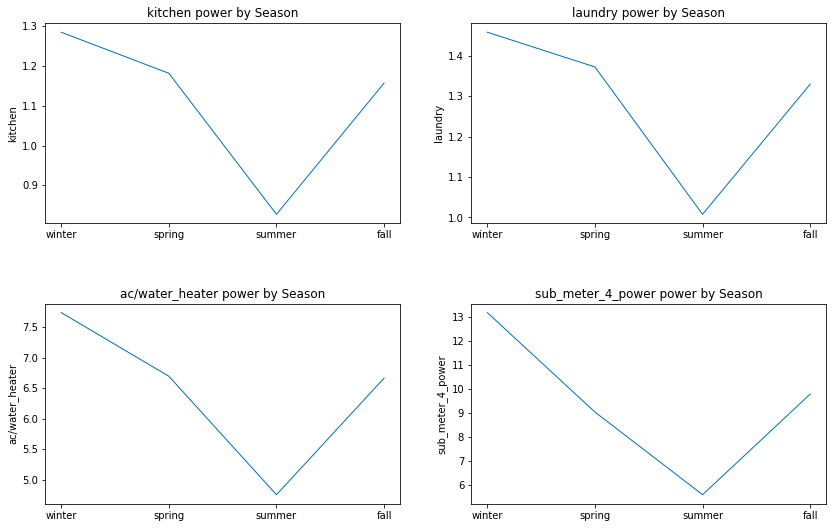

In [32]:
plt.figure(figsize=(14,14))

cols= ['kitchen', 
       'laundry', 
       'ac/water_heater', 
       'sub_meter_4_power', 
       ]

for i, col in enumerate(cols):
    plt.subplot(3,2,i+1)
    plt.subplots_adjust(hspace=.4)
    sns.lineplot(data=power_consumption, x='season', y=col,
                  ci=None,palette="tab10", linewidth=1).set_xticks(power_consumption['season'].unique())    
    plt.xlabel('')
    plt.title(col + ' power by Season')

Now that we have familiarized ourselves with the data, we can investigate further by performing a cluster analysis using our time series data. 